In [62]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
colors = sns.color_palette("husl", 8)

In [63]:
df = pd.read_csv('../data/cleaned_data.csv')
df['order_date'] = pd.to_datetime(df['order_date'])
df['region'] = df['region'].astype('category')

df = df.sort_values(by=['anon_user_id', 'order_date']).reset_index(drop=True)
df['order_number'] = df.groupby('anon_user_id').cumcount() + 1
df['total_orders'] = df.groupby('anon_user_id')['order_number'].transform('max')

df['days_since_last_order'] = df.groupby('anon_user_id')['order_date'].diff().dt.days
df['days_since_last_order'] = df['days_since_last_order'].fillna(0).astype(int)

df['dose_change'] = df.groupby('anon_user_id')['dose_bucket'].diff().fillna(0).astype(int)
 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86817 entries, 0 to 86816
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   anon_user_id           86817 non-null  int64         
 1   order_date             86817 non-null  datetime64[ns]
 2   price_tier             86817 non-null  int64         
 3   dose_bucket            86817 non-null  int64         
 4   region                 86817 non-null  category      
 5   is_partner_pharmacy    86817 non-null  int64         
 6   order_number           86817 non-null  int64         
 7   total_orders           86817 non-null  int64         
 8   days_since_last_order  86817 non-null  int64         
 9   dose_change            86817 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(8)
memory usage: 6.0 MB
None


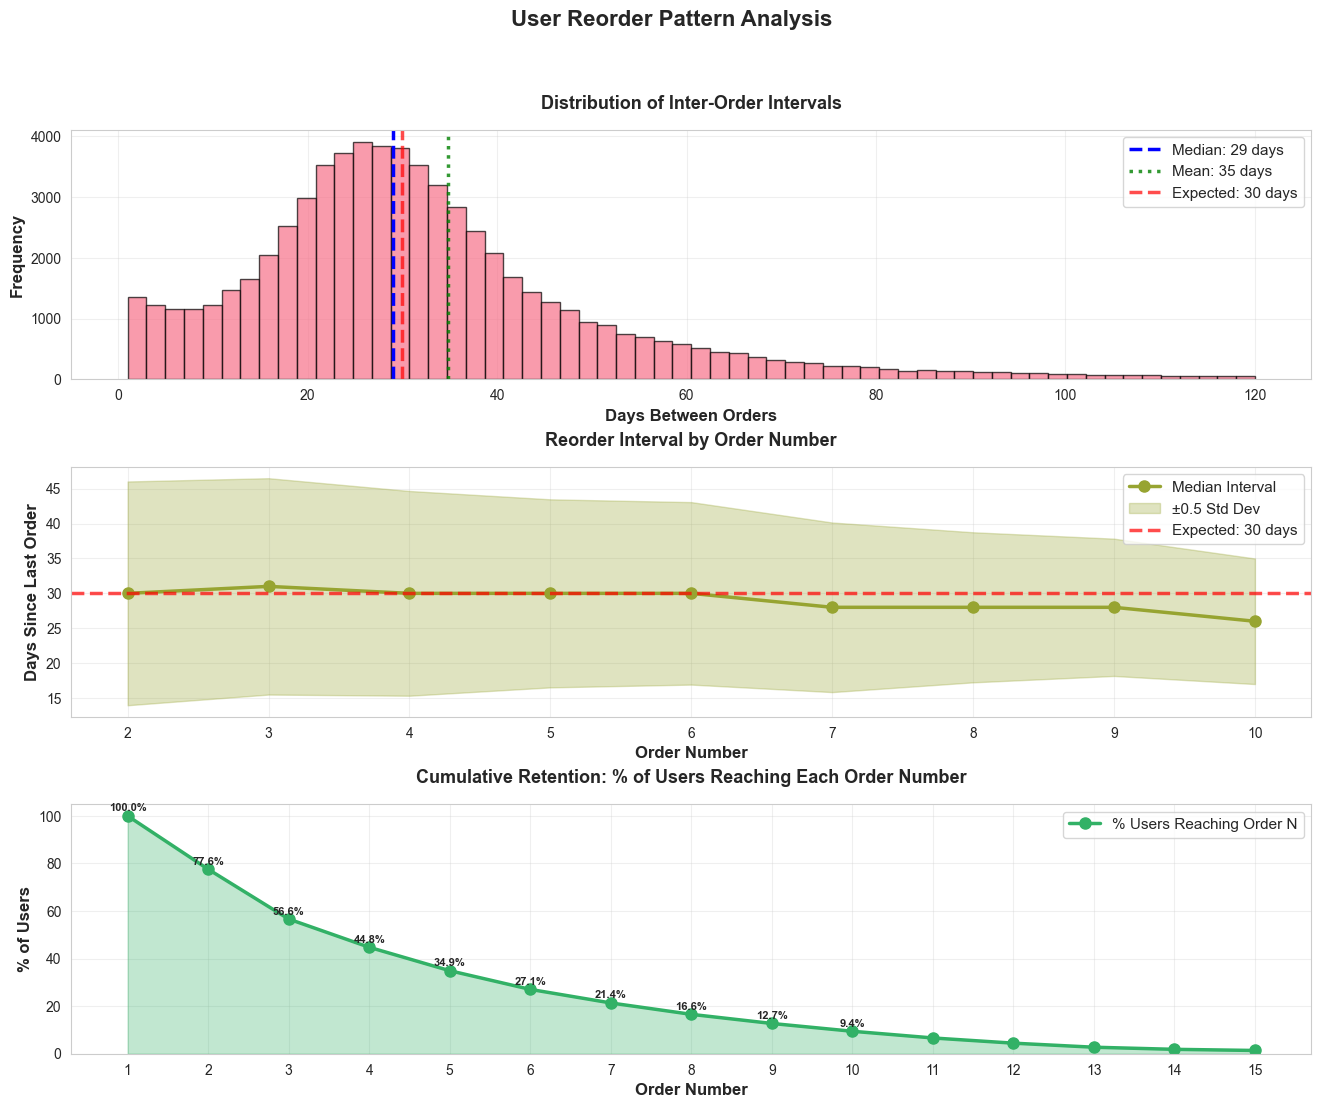

In [64]:
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 1, figure=fig, hspace=0.35)
fig.suptitle('User Reorder Pattern Analysis', fontsize=16, fontweight='bold', y=0.98)

# Distribution of days between orders
ax1 = fig.add_subplot(gs[0, 0])
days_between = df[df['days_since_last_order'] > 0]['days_since_last_order']
ax1.hist(days_between[days_between <= 120], bins=60, edgecolor='black', alpha=0.7, color=colors[0])
median_days = days_between.median()
mean_days = days_between.mean()

ax1.axvline(median_days, color='blue', linestyle='--', linewidth=2.5, 
            label=f'Median: {median_days:.0f} days')
ax1.axvline(mean_days, color='green', linestyle=':', linewidth=2.5, alpha=0.8, 
            label=f'Mean: {mean_days:.0f} days')
ax1.axvline(30, color='red', linestyle='--', linewidth=2.5, alpha=0.7, 
            label='Expected: 30 days')

ax1.set_xlabel('Days Between Orders', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Inter-Order Intervals', fontsize=13, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Reorder interval by order number
ax2 = fig.add_subplot(gs[1, 0])
interval_by_order = df[df['order_number'] <= 10].groupby('order_number')['days_since_last_order'].agg(['mean', 'median', 'std'])
x = interval_by_order.index[1:]

ax2.plot(x, interval_by_order['median'][1:], marker='o', linewidth=2.5, markersize=8, 
         label='Median Interval', color=colors[2])
ax2.fill_between(x, 
                  interval_by_order['median'][1:] - interval_by_order['std'][1:]/2,
                  interval_by_order['median'][1:] + interval_by_order['std'][1:]/2,
                  alpha=0.3, color=colors[2], label='±0.5 Std Dev')
ax2.axhline(30, color='red', linestyle='--', linewidth=2.5, alpha=0.7, 
            label='Expected: 30 days')

ax2.set_xlabel('Order Number', fontsize=12, fontweight='bold')
ax2.set_ylabel('Days Since Last Order', fontsize=12, fontweight='bold')
ax2.set_title('Reorder Interval by Order Number', 
              fontsize=13, fontweight='bold', pad=15)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)
ax2.set_xticks(x)

# Cumulative retention curve
ax3 = fig.add_subplot(gs[2, 0])

total_users = df['anon_user_id'].nunique()
orders_per_user = df.groupby('anon_user_id')['order_number'].max()
order_reach = []

for order_num in range(1, 16):
    users_reaching = (orders_per_user >= order_num).sum()
    order_reach.append(users_reaching / total_users * 100)

ax3.plot(range(1, 16), order_reach, marker='o', linewidth=2.5, markersize=8, 
         color=colors[3], label='% Users Reaching Order N')
ax3.fill_between(range(1, 16), order_reach, alpha=0.3, color=colors[3])

ax3.set_xlabel('Order Number', fontsize=12, fontweight='bold')
ax3.set_ylabel('% of Users', fontsize=12, fontweight='bold')
ax3.set_title('Cumulative Retention: % of Users Reaching Each Order Number', 
              fontsize=13, fontweight='bold', pad=15)
ax3.legend(fontsize=11)
ax3.grid(alpha=0.3)
ax3.set_xticks(range(1, 16))
ax3.set_ylim([0, 105])

for i, pct in enumerate(order_reach[:10], start=1):
    ax3.text(i, pct + 2, f'{pct:.1f}%', ha='center', fontsize=8, fontweight='bold')

plt.show()

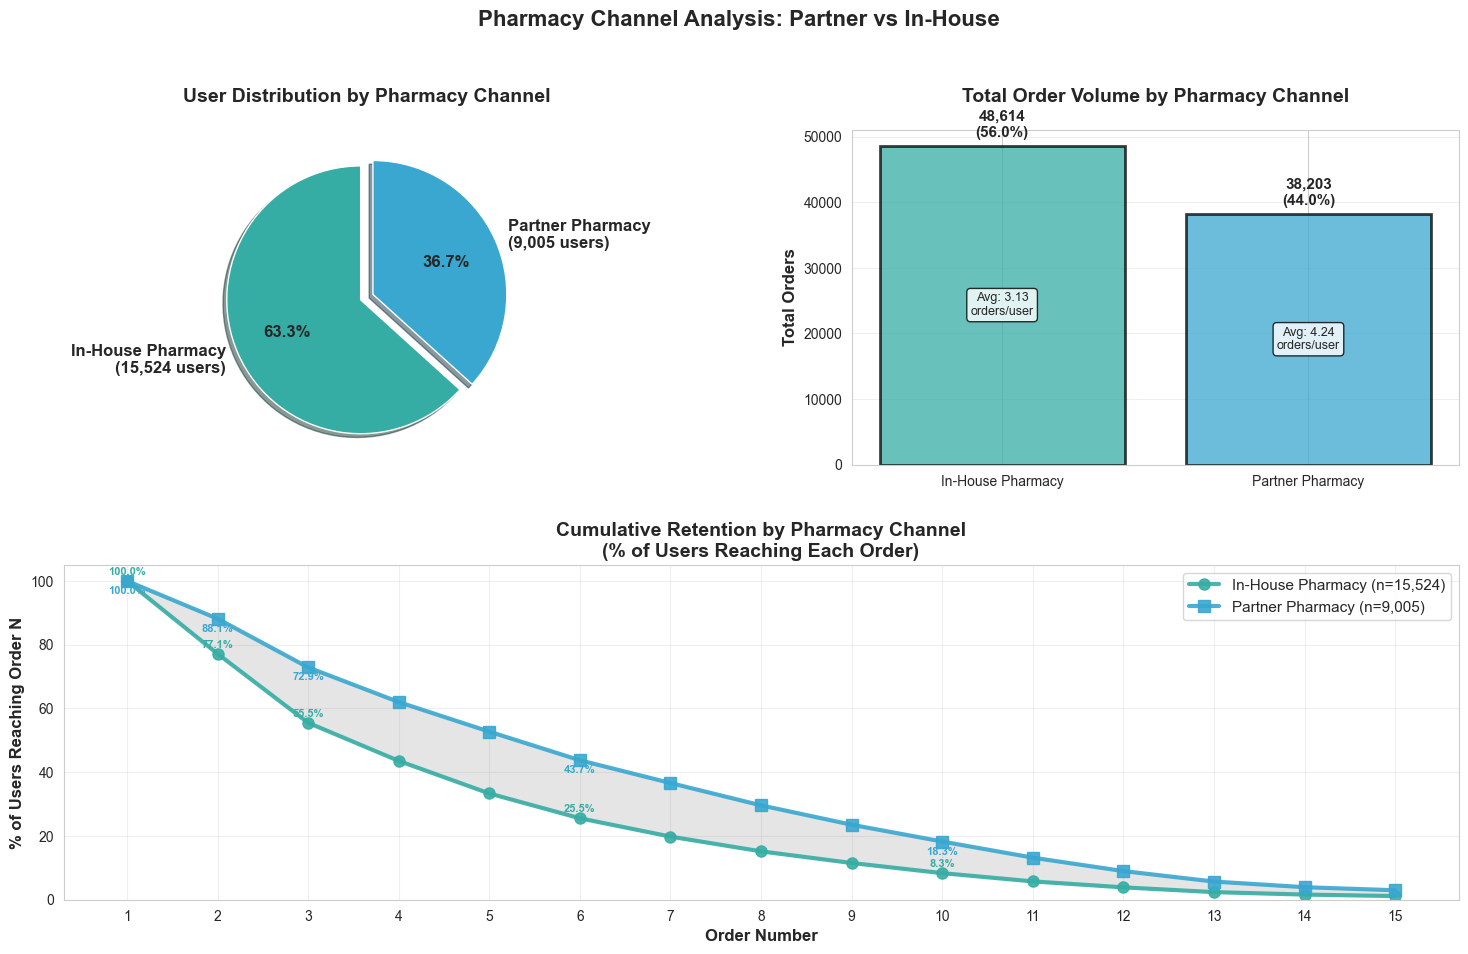

In [65]:
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
fig.suptitle('Pharmacy Channel Analysis: Partner vs In-House', fontsize=16, fontweight='bold', y=1.0)

pharmacy_labels = ['In-House Pharmacy', 'Partner Pharmacy']

# User Distribution by Pharmacy Channel
ax1 = fig.add_subplot(gs[0, 0])

pharmacy_users = df.groupby('is_partner_pharmacy')['anon_user_id'].nunique().reset_index()
pharmacy_users.columns = ['is_partner_pharmacy', 'unique_users']

colors_pie = [colors[4], colors[5]]
explode = (0.05, 0.05)
wedges, texts, autotexts = ax1.pie(pharmacy_users['unique_users'], 
                                    labels=pharmacy_labels,
                                    autopct='%1.1f%%',
                                    colors=colors_pie,
                                    startangle=90,
                                    explode=explode,
                                    shadow=True,
                                    textprops={'fontsize': 12, 'fontweight': 'bold'})
ax1.set_title('User Distribution by Pharmacy Channel', fontsize=14, fontweight='bold', pad=20)

for i, (label, count) in enumerate(zip(pharmacy_labels, pharmacy_users['unique_users'])):
    texts[i].set_text(f'{label}\n({count:,} users)')

# Total Order Volume by Pharmacy Channel
ax3 = fig.add_subplot(gs[0, 1])

pharmacy_order_volume = df.groupby('is_partner_pharmacy').size().reset_index(name='total_orders')

bars = ax3.bar(pharmacy_labels, pharmacy_order_volume['total_orders'], 
              edgecolor='black', alpha=0.75, color=[colors[4], colors[5]], linewidth=2)
ax3.set_ylabel('Total Orders', fontsize=12, fontweight='bold')
ax3.set_title('Total Order Volume by Pharmacy Channel', fontsize=14, fontweight='bold', pad=20)
ax3.grid(alpha=0.3, axis='y')

total_orders = pharmacy_order_volume['total_orders'].sum()
for i, (bar, val) in enumerate(zip(bars, pharmacy_order_volume['total_orders'])):
    height = bar.get_height()
    pct = val / total_orders * 100
    
    ax3.text(bar.get_x() + bar.get_width()/2., height + max(pharmacy_order_volume['total_orders'])*0.02,
            f'{val:,}\n({pct:.1f}%)', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    users = pharmacy_users.iloc[i]['unique_users']
    avg_orders = val / users
    ax3.text(bar.get_x() + bar.get_width()/2., height * 0.5,
            f'Avg: {avg_orders:.2f}\norders/user', 
            ha='center', va='center', fontsize=9, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black'))

# Cumulative Retention by Pharmacy Channel
ax2 = fig.add_subplot(gs[1, :])

user_orders_by_pharmacy = df.groupby(['anon_user_id', 'is_partner_pharmacy'])['total_orders'].first().reset_index()

direct_orders = user_orders_by_pharmacy[user_orders_by_pharmacy['is_partner_pharmacy'] == 0]['total_orders']
total_direct = len(direct_orders)
direct_retention = []
for order_num in range(1, 16):
    users_reaching = (direct_orders >= order_num).sum()
    direct_retention.append(users_reaching / total_direct * 100)

partner_orders = user_orders_by_pharmacy[user_orders_by_pharmacy['is_partner_pharmacy'] == 1]['total_orders']
total_partner = len(partner_orders)
partner_retention = []
for order_num in range(1, 16):
    users_reaching = (partner_orders >= order_num).sum()
    partner_retention.append(users_reaching / total_partner * 100)

order_numbers = list(range(1, 16))
ax2.plot(order_numbers, direct_retention, marker='o', linewidth=3, markersize=8, 
         label=f'In-House Pharmacy (n={total_direct:,})', color=colors[4], alpha=0.9)
ax2.plot(order_numbers, partner_retention, marker='s', linewidth=3, markersize=8, 
         label=f'Partner Pharmacy (n={total_partner:,})', color=colors[5], alpha=0.9)

ax2.fill_between(order_numbers, direct_retention, partner_retention, alpha=0.2, color='gray')

ax2.set_xlabel('Order Number', fontsize=12, fontweight='bold')
ax2.set_ylabel('% of Users Reaching Order N', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Retention by Pharmacy Channel\n(% of Users Reaching Each Order)', 
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='upper right')
ax2.grid(alpha=0.3)
ax2.set_xticks(order_numbers)
ax2.set_ylim([0, 105])

key_orders = [1, 2, 3, 6, 10]
for order_idx in key_orders:
    if order_idx <= len(direct_retention):
        idx = order_idx - 1
        ax2.text(order_idx, direct_retention[idx] + 2, f'{direct_retention[idx]:.1f}%', 
                ha='center', fontsize=8, color=colors[4], fontweight='bold')
        ax2.text(order_idx, partner_retention[idx] - 4, f'{partner_retention[idx]:.1f}%', 
                ha='center', fontsize=8, color=colors[5], fontweight='bold')

plt.show()

/var/folders/fb/p4cxp1ns7x7fdvm4ccm9_zth0000gn/T/ipykernel_5102/1577350912.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_orders = df.groupby('region')['anon_user_id'].nunique().reset_index()
/var/folders/fb/p4cxp1ns7x7fdvm4ccm9_zth0000gn/T/ipykernel_5102/1577350912.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_by_region, labels=regions_for_plot, patch_artist=True)
/var/folders/fb/p4cxp1ns7x7fdvm4ccm9_zth0000gn/T/ipykernel_5102/1577350912.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt t

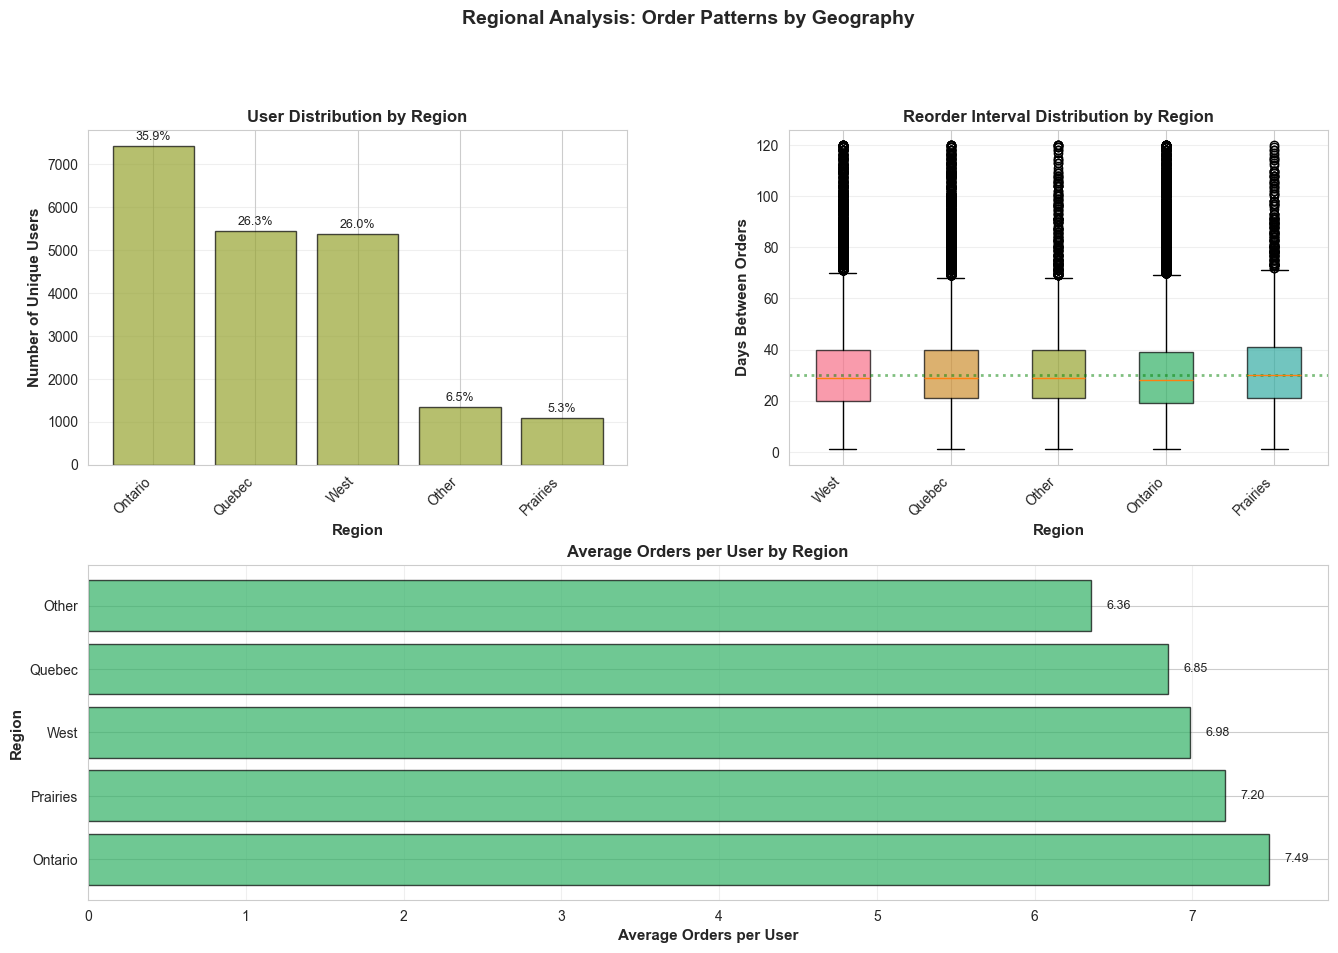

In [69]:
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
fig.suptitle('Regional Analysis: Order Patterns by Geography', fontsize=14, fontweight='bold', y=1.00)

# User Distribution by Region
ax1 = fig.add_subplot(gs[0, 0])

region_orders = df.groupby('region')['anon_user_id'].nunique().reset_index()
region_orders.columns = ['region', 'unique_users']
region_orders = region_orders.sort_values('unique_users', ascending=False)

ax1.bar(region_orders['region'], region_orders['unique_users'], 
       edgecolor='black', alpha=0.7, color=colors[2])
ax1.set_xlabel('Region', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Unique Users', fontsize=11, fontweight='bold')
ax1.set_title('User Distribution by Region', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')
ax1.grid(alpha=0.3, axis='y')

total = region_orders['unique_users'].sum()
for i, (idx, row) in enumerate(region_orders.iterrows()):
    pct = row['unique_users'] / total * 100
    ax1.text(i, row['unique_users'] + max(region_orders['unique_users'])*0.02, 
            f'{pct:.1f}%', ha='center', fontsize=9)

# Reorder Interval Distribution by Region
ax2 = fig.add_subplot(gs[0, 1])

regions_for_plot = df[df['days_since_last_order'] > 0]['region'].unique()
data_by_region = [df[(df['region'] == r) & (df['days_since_last_order'] > 0) & 
                      (df['days_since_last_order'] <= 120)]['days_since_last_order'] 
                  for r in regions_for_plot]
bp = ax2.boxplot(data_by_region, labels=regions_for_plot, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_xlabel('Region', fontsize=11, fontweight='bold')
ax2.set_ylabel('Days Between Orders', fontsize=11, fontweight='bold')
ax2.set_title('Reorder Interval Distribution by Region', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')
ax2.grid(alpha=0.3, axis='y')
ax2.axhline(30, color='green', linestyle=':', linewidth=2, alpha=0.5)

# Average Orders per User by Region
ax3 = fig.add_subplot(gs[1, :])

region_avg_orders = df.groupby('region')['total_orders'].mean().reset_index()
region_avg_orders = region_avg_orders.sort_values('total_orders', ascending=False)

bars = ax3.barh(region_avg_orders['region'], region_avg_orders['total_orders'], 
               edgecolor='black', alpha=0.7, color=colors[3])
ax3.set_xlabel('Average Orders per User', fontsize=11, fontweight='bold')
ax3.set_ylabel('Region', fontsize=11, fontweight='bold')
ax3.set_title('Average Orders per User by Region', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3, axis='x')

for i, (idx, row) in enumerate(region_avg_orders.iterrows()):
    ax3.text(row['total_orders'] + 0.1, i, f'{row["total_orders"]:.2f}', 
            va='center', fontsize=9)

plt.show()

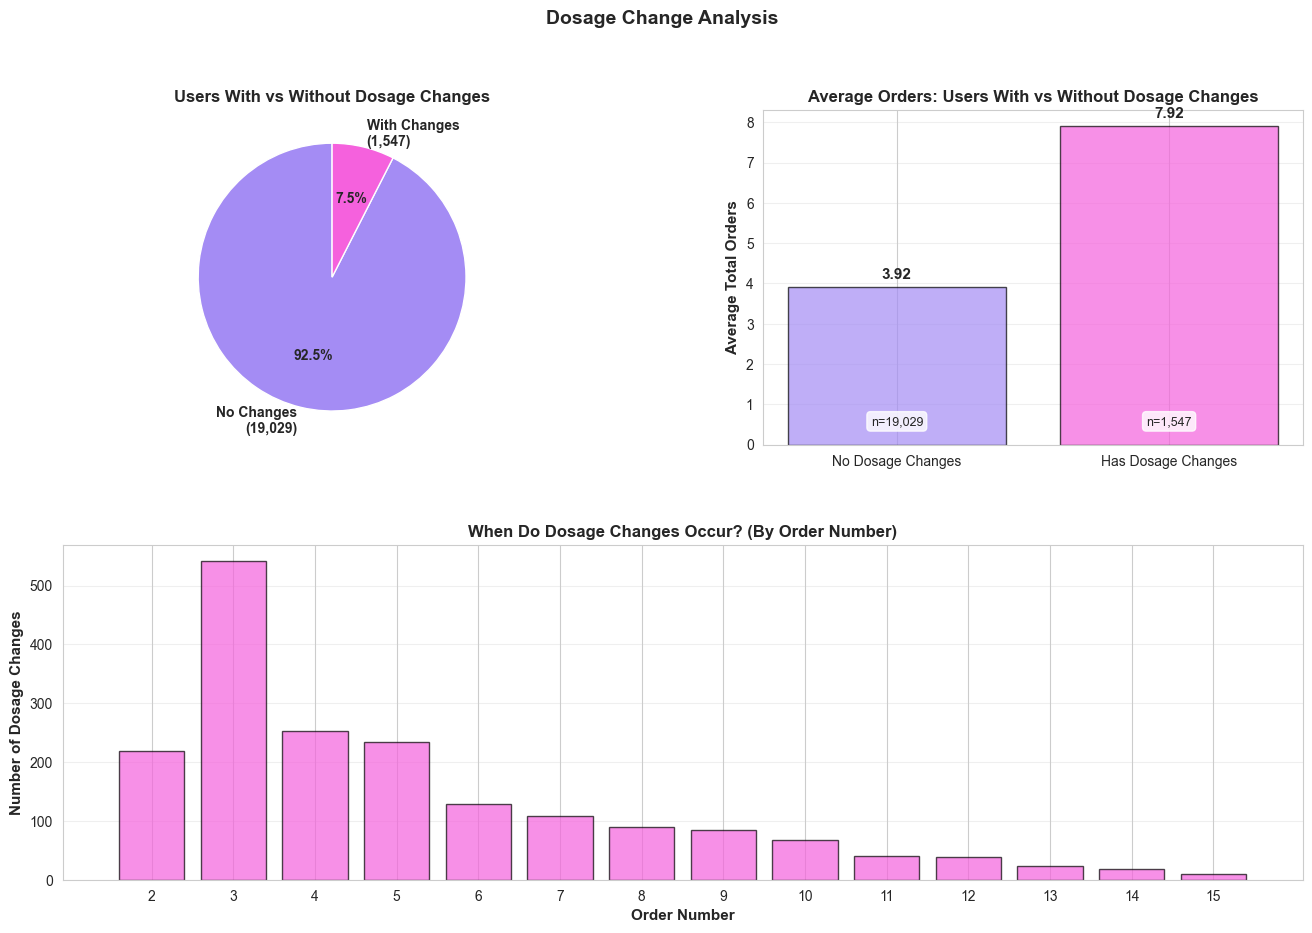

In [66]:
# Calculate dosage changes
dosage_change_counts = df[df['dose_change'] != 0].groupby('anon_user_id').size().reset_index(name='dosage_change_count')
total_users = df['anon_user_id'].nunique()
users_with_changes = len(dosage_change_counts)
users_without_changes = total_users - users_with_changes

user_level = df.groupby('anon_user_id').agg({
    'total_orders': 'first',
    'dose_change': lambda x: (x != 0).sum()
}).reset_index()
user_level.columns = ['anon_user_id', 'total_orders', 'num_dosage_changes']
user_level['has_dosage_change'] = user_level['num_dosage_changes'] > 0

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
fig.suptitle('Dosage Change Analysis', fontsize=14, fontweight='bold', y=0.98)

# Pie chart - users with vs without dosage changes
ax1 = fig.add_subplot(gs[0, 0])
sizes = [users_without_changes, users_with_changes]
labels_dose = [f'No Changes\n({users_without_changes:,})', 
               f'With Changes\n({users_with_changes:,})']
colors_dose = [colors[6], colors[7]]
wedges, texts, autotexts = ax1.pie(sizes, labels=labels_dose, autopct='%1.1f%%',
                                    colors=colors_dose, startangle=90,
                                    textprops={'fontsize': 10, 'fontweight': 'bold'})
ax1.set_title('Users With vs Without Dosage Changes', fontsize=12, fontweight='bold')

# Average orders - with vs without dosage changes
ax2 = fig.add_subplot(gs[0, 1])
avg_orders_comparison = user_level.groupby('has_dosage_change')['total_orders'].mean()
labels_comparison = ['No Dosage Changes', 'Has Dosage Changes']
bars = ax2.bar(labels_comparison, avg_orders_comparison.values, 
              edgecolor='black', alpha=0.7, color=[colors[6], colors[7]])
ax2.set_ylabel('Average Total Orders', fontsize=11, fontweight='bold')
ax2.set_title('Average Orders: Users With vs Without Dosage Changes', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

for i, val in enumerate(avg_orders_comparison.values):
    ax2.text(i, val + 0.2, f'{val:.2f}', ha='center', fontsize=11, fontweight='bold')

for i, has_change in enumerate([False, True]):
    n = (user_level['has_dosage_change'] == has_change).sum()
    ax2.text(i, 0.5, f'n={n:,}', ha='center', fontsize=9, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 3: Dosage change timing 
ax3 = fig.add_subplot(gs[1, :])
dose_change_orders = df[df['dose_change'] != 0]['order_number'].value_counts().sort_index()
if len(dose_change_orders) > 0:
    dose_change_orders = dose_change_orders[dose_change_orders.index <= 15]
    ax3.bar(dose_change_orders.index, dose_change_orders.values, 
           edgecolor='black', alpha=0.7, color=colors[7])
    ax3.set_xlabel('Order Number', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Number of Dosage Changes', fontsize=11, fontweight='bold')
    ax3.set_title('When Do Dosage Changes Occur? (By Order Number)', fontsize=12, fontweight='bold')
    ax3.grid(alpha=0.3, axis='y')
    ax3.set_xticks(dose_change_orders.index)

plt.show()

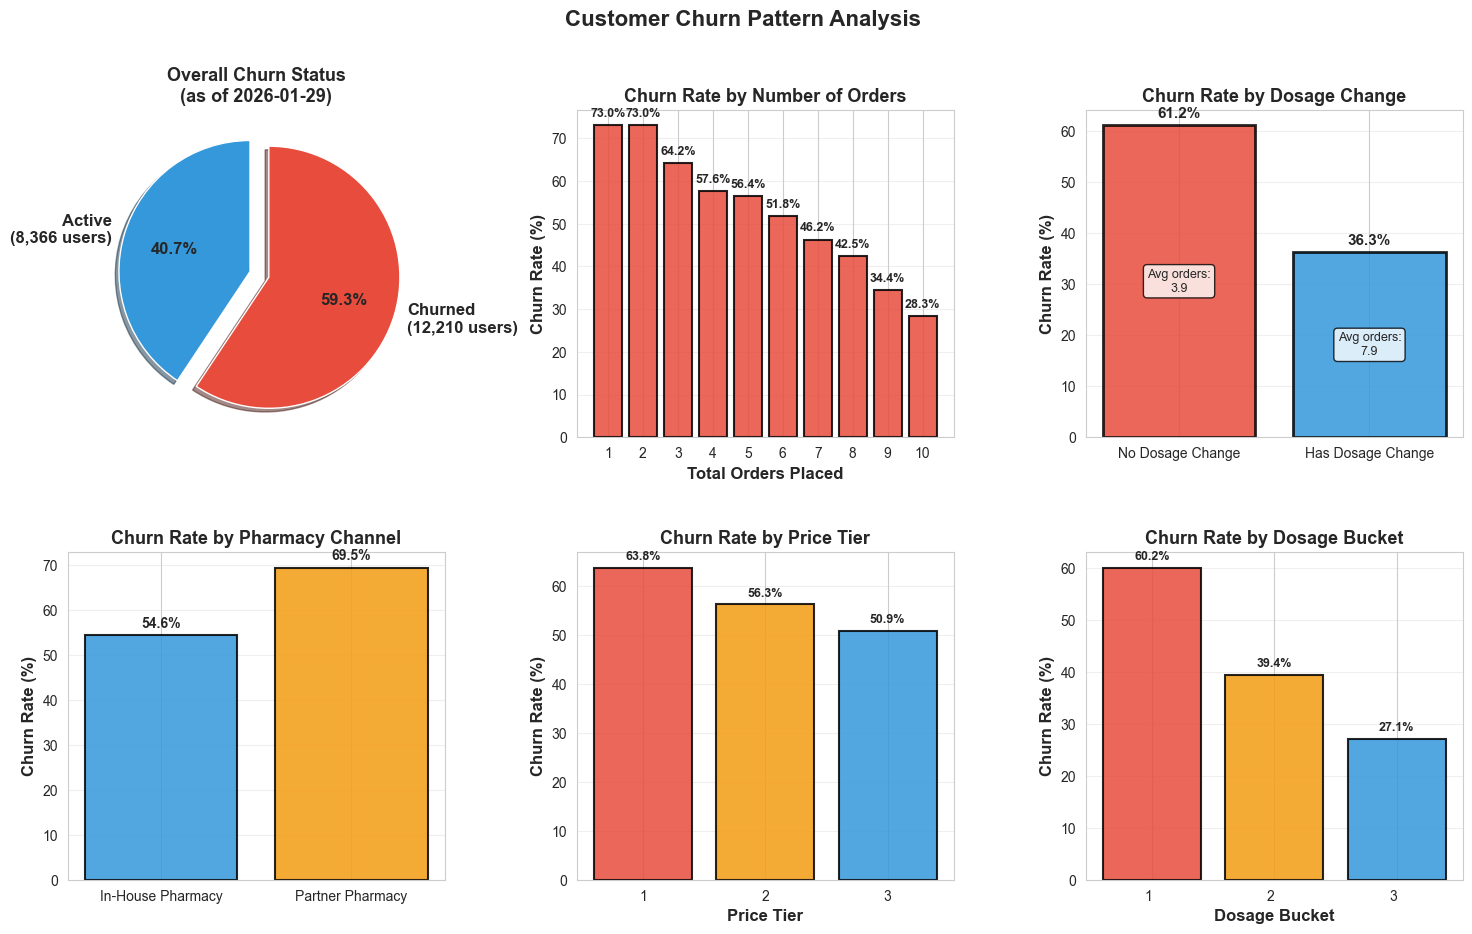

In [68]:
# Define churn threshold
CHURN_THRESHOLD = 45
ANALYSIS_DATE = df['order_date'].max()

# Prepare user-level churn data
user_churn_data = df.groupby('anon_user_id').agg({
    'order_date': ['min', 'max', 'count'],
}).reset_index()

user_churn_data.columns = ['anon_user_id', 'first_order', 'last_order', 'total_orders']

# Assign most used dosage bucket per customer
user_dosage = df.groupby('anon_user_id')['dose_bucket'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]).reset_index()
user_dosage.columns = ['anon_user_id', 'primary_dose_bucket']

user_price_tier = df.groupby('anon_user_id')['price_tier'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]).reset_index()
user_price_tier.columns = ['anon_user_id', 'primary_price_tier']

user_pharmacy_type = df.groupby('anon_user_id')['is_partner_pharmacy'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]).reset_index()
user_pharmacy_type.columns = ['anon_user_id', 'primary_pharmacy_type']

user_churn_data = user_churn_data.merge(user_dosage, on='anon_user_id', how='left')
user_churn_data = user_churn_data.merge(user_price_tier, on='anon_user_id', how='left')
user_churn_data = user_churn_data.merge(user_pharmacy_type, on='anon_user_id', how='left')

user_churn_data['days_since_last_order'] = (ANALYSIS_DATE - user_churn_data['last_order']).dt.days
user_churn_data['is_churned'] = user_churn_data['days_since_last_order'] > CHURN_THRESHOLD
user_churn_data['active_days'] = (user_churn_data['last_order'] - user_churn_data['first_order']).dt.days
user_churn_data['active_months'] = (user_churn_data['active_days'] / 30).astype(int)

COLOR_1 = '#3498db'
COLOR_2 = '#e74c3c'
COLOR_3 = '#f39c12'

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 3, figure=fig, hspace=0.35, wspace=0.35)
fig.suptitle('Customer Churn Pattern Analysis', fontsize=16, fontweight='bold', y=0.98)

# Overall churn rate
ax1 = fig.add_subplot(gs[0, 0])

churn_counts = user_churn_data['is_churned'].value_counts()
labels_churn = ['Active', 'Churned']
sizes_churn = [churn_counts.get(False, 0), churn_counts.get(True, 0)]
colors_churn = [COLOR_1, COLOR_2]
explode = (0.05, 0.1)

wedges, texts, autotexts = ax1.pie(sizes_churn, 
                                     labels=labels_churn,
                                     autopct='%1.1f%%',
                                     colors=colors_churn,
                                     startangle=90,
                                     explode=explode,
                                     shadow=True,
                                     textprops={'fontsize': 12, 'fontweight': 'bold'})

ax1.set_title(f'Overall Churn Status\n(as of {ANALYSIS_DATE.date()})', 
              fontsize=13, fontweight='bold')

for i, (label, count) in enumerate(zip(labels_churn, sizes_churn)):
    texts[i].set_text(f'{label}\n({count:,} users)')

# Churn by total orders
ax2 = fig.add_subplot(gs[0, 1])

churn_by_orders = user_churn_data[user_churn_data['total_orders'] <= 10].groupby('total_orders')['is_churned'].agg(['sum', 'count', 'mean'])
churn_by_orders['churn_rate'] = churn_by_orders['mean'] * 100

ax2.bar(churn_by_orders.index, churn_by_orders['churn_rate'], 
        edgecolor='black', alpha=0.85, color=COLOR_2, linewidth=1.5)
ax2.set_xlabel('Total Orders Placed', fontsize=12, fontweight='bold')
ax2.set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Churn Rate by Number of Orders', 
              fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')
ax2.set_xticks(churn_by_orders.index)

for i, (idx, row) in enumerate(churn_by_orders.iterrows()):
    ax2.text(idx, row['churn_rate'] + 2, f"{row['churn_rate']:.1f}%", 
            ha='center', fontsize=9, fontweight='bold')

# Churn by dosage change
ax3 = fig.add_subplot(gs[0, 2])

user_dosage_change = df.groupby('anon_user_id')['dose_change'].apply(lambda x: (x != 0).any()).reset_index()
user_dosage_change.columns = ['anon_user_id', 'has_dosage_change']

user_churn_with_dosage = user_churn_data.merge(user_dosage_change, on='anon_user_id', how='left')
user_churn_with_dosage['has_dosage_change'] = user_churn_with_dosage['has_dosage_change'].fillna(False)

overall_churn = user_churn_with_dosage.groupby('has_dosage_change')['is_churned'].agg(['sum', 'count', 'mean'])
overall_churn['churn_rate'] = overall_churn['mean'] * 100

labels_dosage = ['No Dosage Change', 'Has Dosage Change']
x_pos = np.arange(len(labels_dosage))

bars = ax3.bar(x_pos, overall_churn['churn_rate'], 
               edgecolor='black', alpha=0.85, color=[COLOR_2, COLOR_1], linewidth=2)

ax3.set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
ax3.set_title('Churn Rate by Dosage Change', 
              fontsize=13, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(labels_dosage)
ax3.grid(alpha=0.3, axis='y')

for i, (bar, idx) in enumerate(zip(bars, overall_churn.index)):
    height = bar.get_height()
    count = overall_churn.loc[idx, 'count']
    churned = overall_churn.loc[idx, 'sum']
    
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    avg_orders = user_churn_with_dosage[user_churn_with_dosage['has_dosage_change'] == idx]['total_orders'].mean()
    ax3.text(bar.get_x() + bar.get_width()/2., height * 0.5,
            f'Avg orders:\n{avg_orders:.1f}', 
            ha='center', va='center', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black'))

# Churn by pharmacy channel
ax5 = fig.add_subplot(gs[1, 0])

churn_by_pharmacy = user_churn_data.groupby('primary_pharmacy_type')['is_churned'].agg(['sum', 'count', 'mean'])
churn_by_pharmacy['churn_rate'] = churn_by_pharmacy['mean'] * 100

pharmacy_labels = ['In-House Pharmacy', 'Partner Pharmacy']
x_pos = np.arange(len(churn_by_pharmacy))

bars = ax5.bar(x_pos, churn_by_pharmacy['churn_rate'], 
               edgecolor='black', alpha=0.85, color=[COLOR_1, COLOR_3], linewidth=1.5)

ax5.set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
ax5.set_title('Churn Rate by Pharmacy Channel', fontsize=13, fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(pharmacy_labels)
ax5.grid(alpha=0.3, axis='y')

for i, (bar, idx) in enumerate(zip(bars, churn_by_pharmacy.index)):
    height = bar.get_height()
    count = churn_by_pharmacy.loc[idx, 'count']
    churned = churn_by_pharmacy.loc[idx, 'sum']
    ax5.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Churn by price tier
ax6 = fig.add_subplot(gs[1, 1])

churn_by_price = user_churn_data.groupby('primary_price_tier')['is_churned'].agg(['sum', 'count', 'mean'])
churn_by_price['churn_rate'] = churn_by_price['mean'] * 100
churn_by_price = churn_by_price.sort_values('churn_rate', ascending=False)

price_colors = [COLOR_2, COLOR_3, COLOR_1] * (len(churn_by_price) // 3 + 1)
price_colors = price_colors[:len(churn_by_price)]

bars = ax6.bar(range(len(churn_by_price)), churn_by_price['churn_rate'], 
               edgecolor='black', alpha=0.85, color=price_colors, linewidth=1.5)
ax6.set_xlabel('Price Tier', fontsize=12, fontweight='bold')
ax6.set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
ax6.set_title('Churn Rate by Price Tier', fontsize=13, fontweight='bold')
ax6.set_xticks(range(len(churn_by_price)))
ax6.set_xticklabels(churn_by_price.index)
ax6.grid(alpha=0.3, axis='y')

for i, (idx, row) in enumerate(churn_by_price.iterrows()):
    ax6.text(i, row['churn_rate'] + 1, f"{row['churn_rate']:.1f}%", 
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Churn by dosage bucket
ax7 = fig.add_subplot(gs[1, 2])

churn_by_dose = user_churn_data.groupby('primary_dose_bucket')['is_churned'].agg(['sum', 'count', 'mean'])
churn_by_dose['churn_rate'] = churn_by_dose['mean'] * 100
churn_by_dose = churn_by_dose.sort_values('churn_rate', ascending=False)

dose_colors = [COLOR_2, COLOR_3, COLOR_1] * (len(churn_by_dose) // 3 + 1)
dose_colors = dose_colors[:len(churn_by_dose)]

bars = ax7.bar(range(len(churn_by_dose)), churn_by_dose['churn_rate'], 
               edgecolor='black', alpha=0.85, color=dose_colors, linewidth=1.5)
ax7.set_xlabel('Dosage Bucket', fontsize=12, fontweight='bold')
ax7.set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
ax7.set_title('Churn Rate by Dosage Bucket', fontsize=13, fontweight='bold')
ax7.set_xticks(range(len(churn_by_dose)))
ax7.set_xticklabels(churn_by_dose.index, ha='right')
ax7.grid(alpha=0.3, axis='y')

for i, (idx, row) in enumerate(churn_by_dose.iterrows()):
    ax7.text(i, row['churn_rate'] + 1, f"{row['churn_rate']:.1f}%", 
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.show()